
The basic form of a recommender system uses _memory based algorithms_. This uses the past interactions users have with possible items in the market place. These types of algorithms utilize that similar users have similar rating behavior.

1. _User-based collaborative filtering_: for target user A, we use the weighted average of similar users for each item
2. _Item-based collaborative filtering_: for any item B, determine set S, which are items similar to B. Then for target user A, find set S to rate for B.

Ratings can be both _explicit_ and/or _implicit_. Some examples of explicit ratings include:
- continuous ratings, interval based ratings, ordinal rating (all numerical scale - ie. 1 to 5, very bad to very good, etc)
- binary rating (1 or 0, like or dislike)
- unary rating (like or no action) - can't really penalize for a no action

To better understand some concepts, lets load in a toy data set. 

Please refer to the code from [this blessed blog post](http://www.gregreda.com/2013/10/26/using-pandas-on-the-movielens-dataset/)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [8]:

# pass in column names for each CSV
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,
                    encoding='latin-1')

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

# the movies file contains columns indicating the movie's genres
# let's only load the first five columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(5),
                     encoding='latin-1')

# create one merged DataFrame
movie_ratings = pd.merge(movies, ratings)
lens = pd.merge(movie_ratings, users)

In [10]:
lens.sample(4)

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
74149,744,Michael Collins (1996),11-Oct-1996,NaN,http://us.imdb.com/M/title-exact?Michael%20Col...,666,3,880313661,44,M,administrator,61820
56551,89,Blade Runner (1982),01-Jan-1982,NaN,http://us.imdb.com/M/title-exact?Blade%20Runne...,201,3,884112245,27,M,writer,E2A4H
49478,479,Vertigo (1958),01-Jan-1958,NaN,http://us.imdb.com/M/title-exact?Vertigo%20(1958),929,4,879640329,44,M,scientist,53711
68527,403,Batman (1989),01-Jan-1989,NaN,http://us.imdb.com/M/title-exact?Batman%20(1989),551,3,892782807,25,M,programmer,55414


One common property of many recommender systems is the _long tail_ property. This property shows that only a small number of items are frequently rated. As a result, there is a highly skewed distribution. Consider:
- This biases a recommender system to just recommend _popular_ items. This leads to repeated recommendations
- This implies that highly rated items are usually fewer in number

This can be observed below.

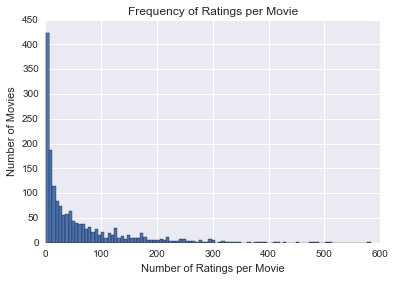

In [11]:
ratings = []
for g, df_g in df_lens.groupby(['movie_id', 'title']):
    ratings.append(dict(
        number_of_ratings=len(df_g),
        movie_id = g[0],
        title=g[1]
        ))
df_ratings = pd.DataFrame(ratings)
plt.hist(df_ratings['number_of_ratings'], bins=100)
plt.title('Frequency of Ratings per Movie')
plt.xlabel("Number of Ratings per Movie")
plt.ylabel("Number of Movies")

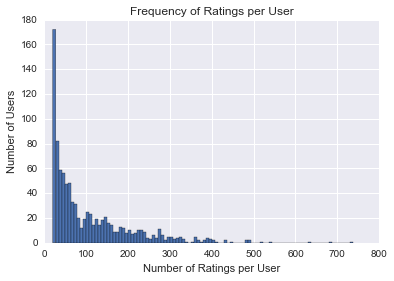

In [12]:
ratings = []
for g, df_g in df_lens.groupby(['user_id']):
    ratings.append(dict(
        number_of_ratings=len(df_g),
        use_id = g
        ))
df_ratings = pd.DataFrame(ratings)
plt.hist(df_ratings['number_of_ratings'], bins=100)
plt.title('Frequency of Ratings per User')
plt.xlabel("Number of Ratings per User")
plt.ylabel("Number of Users")

# User-Item Recommender

The most simple method, is to figure out what user is most similar by conceptualizing the problem as nearest neighbour. For a given user, what user is most similar? If we assume $I_u$ is the set of items rated by user $u$, and $I_v$ is the set of user v, we can use the item ratings per user as the feature vector.

For two users, the similarity can be computed $Sim(u,v)$. For each item, $j$, we can then predict the ranking for that item from the given user.

In [13]:
n_users = lens['user_id'].max()
n_items = lens['movie_id'].max()


For our purposes, lets use cross validation to split the data into two groups.

In [14]:
from sklearn import cross_validation as cv
df_train, df_test = cv.train_test_split(lens, test_size=0.2)

Now lets generate the user-item matrix which is an $m \ x\ n$ matrix, where $m$ is the number of users and $n$ is the number of movies being rated.

In [15]:
def generate_train_matrix(df):
    train_matrix = np.zeros((n_users, n_items))
    for i in df.itertuples():
        # assume that row id is always an integer from 1 to n
        row_i = i.user_id - 1
        # same for column id
        col_i = i.movie_id - 1
        train_matrix[row_i, col_i] = i.rating
    return train_matrix
train_matrix = generate_train_matrix(df_train)
print train_matrix.shape

(943, 1682)


So to determine which users are similar, compute the feature vector across 2 distinct rows. The feature function can be different options including _cosine similarity_ and _pearson's correlation_. 

For each item per user, the item rating can be predicted by using the mean rating of the most similar set of users. The most similar users is defined as $P_u(j)$, or the $k$-nearest neighbours. One problem to adjust for is bias that a user has in ratings. For example, one user may have a tendency to rate items higher while another user always rates items lower. To adjust for this, each rating of the user needs to be centered on the mean of their ratings. 

In other words, for item $j$ and user $u$, the mean-centered rating $s_{uj}$ is defined by subtracting the mean from the raw rating $r_{uj}$. 

$$ s_{uj} = r_{uj} - u_{u}  \bigvee u \ \epsilon \{1,...m\} $$

The mean rating per user, $u_u$, is computed below. (This represents the sum of ratings divided by the numbers of items with rating). $I_u=\text{number of items with ratings}$

$$ u_u = \frac{\sum_{k\epsilon I_u} r_{uk}}{|I_u|} $$


So now that the mean-centered rating is formulated, we can rearrange this to compute the true rating of an item per user. 

$$ r_{uj} = u_u + s_{uj} $$

$u_u$ is easily computed, as we assume that we already have some ratings for a given user. On the other hand, we can estimate what $s_{uj}$ is per user. The estimate of $s_{uj}$, $\hat{s_{uj}}$, can be determined by a weighted sum of all other users, where the weight represents how similar user $u$ is to user $v$. 


$$ \hat{r_{uj}} = u_u + \hat{s_{uj}} $$

This weighted sum can be written as:

$$ 
    \hat{s_{uj}} = \frac
        {s_{u_1j}Sim(u,u_1)  + s_{u_2j}Sim(u,u_2)  + ... + s_{u_mj}Sim(u,u_m)}
        {|Sim(u,u_1)|  + |Sim(u,u_2)|  + ... + |Sim(u,u_m)|}
$$
Where the numerator is the weights applied to each mean-centered rating for the item per user. The denominator represents the normalization needed to limit the scale applied by similarity weight of users.

With many users, this computation can become expensive. One shortcut around an expensive computation time is to only compute the ratings for users who are most similar - aka, _k-Nearest Neighbours_.

In [17]:

from sklearn.neighbors import NearestNeighbors
k = n_users/10
knn = NearestNeighbors(n_neighbors=k + 1)
knn.fit(train_matrix)
def mean_for_non_empty_cells(mat, axis=1):
    return np.sum(mat, axis=axis) / np.sum(mat > 0, axis=axis)

def estimate_weight(item_index, user_index, nn_index, nn_weights, rating_matrix):
    user_mean_rating = mean_for_non_empty_cells(rating_matrix[user_index,:], axis=0)
    # compute mean for non zero entries
    nn_rating_matrix = rating_matrix[nn_index,:]
    nn_mean_rating = mean_for_non_empty_cells(nn_rating_matrix, axis=1)
    
    nn_item_rating_vector = rating_matrix[nn_index, item_index]
    num = np.sum((nn_item_rating_vector - nn_mean_rating).dot(nn_weights))
    dem =  np.sum(np.abs(nn_weights))
    return user_mean_rating + num / dem

Y = np.zeros(len(df_test))
i = 0
for g, df_g in df_test.groupby('user_id'):
    user_id = int(g)
    user_index = user_id - 1
    user_row = train_matrix[user_index,:]
    user_row = np.reshape(user_row, (1, n_items))
    
    nn_weights, nn_index = knn.kneighbors(user_row)
    if nn_weights[0,0] == 0: # first neighbour is itself
        nn_index = nn_index[0, 1:k+1] # drop the first neighbour if it is itself
        nn_weights = nn_weights[0,1:k+1]
    else:
        print 'new user'
        nn_index = nn_index[0, 0:k] # drop the last neighbour if first is not itself
        nn_weights = nn_weights[0,1:k]
    for item_id in df_g['movie_id'].tolist(): 
        item_index = item_id - 1
        Y[i] = estimate_weight(item_index, user_index, nn_index, nn_weights, train_matrix,)
        i += 1


In [19]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(df_test['rating'], Y))

3.290392364835844

The results are actually quite terrible... as this is the most basic model, lets explore some other alternatives!

## Variations in User-item Neighbourhood Methods

- Variations in similarity function
    - Can use `Pearson's Correlation Coefficient` instead
    - Can apply a `Discounted Similarity`. This is also known as significance weighting. if the number of similar items is below threshold $\beta$, then the similarity coefficient of the user pair is down weighted. 
- Variations in prediction function
    - Can use a z score method. So vary the weight by multiplying by the standard deviation of user ratings. 
    - Current set up is a regression problem. Can be restructured to be more like a classification problem (dont' care about ranking of items)
    
- Impact of long tail
    - Some items are highly rated. These items are generally noisy. Similar to stop words, the movie ratings have little to no value. We can filter thigs by weighing with the _Inverse Document Frequency_ (idf). This adds a weight $w_j$ for each item $j$. 


$$ w_j = log(\frac{m}{m_j}), j=\text{item}, m=\text{Number of Users}, m_j = \text{Number of Users rated j} $$


$$ r_{j \text{ weighted}} = r_j*w_j $$

# Item - Item Recommender

The other common approach is to use item pairings. Instead of finding similar users, the goal is to find similar items. So given the rating matrix, compute similarities between columns rather than rows!


For item $i$, find users who rated item $i$ to be the set $U_i$. We then copmpute the similairty of items using the $adjustd$ cosine similarity between columns $i$ and $j$. 

$$ AdjustedCosine(i,j) = \frac
    {\sum_{u \epsilon U_i \bigcap U_j} s_{ui}* s_{uj} }
    {\sqrt{\sum_{u \epsilon U_i \bigcap U_j} s_{ui}^2} \sqrt{\sum_{u \epsilon U_i \bigcap U_j} s_{uj}^2}} 
$$

This just computes the cosine similarity between column vectors. 

For a given item $j$, we find similar items $t$. We say that the set of column vectors $Q_t(u)$ is the column vector belonging to similar items $t$. To actually compute ratings for user $u$ and item $j$, we compute:

$$ \hat{r_{ui}} =  \frac
    {\sum_{j\epsilon Q_t(u)} AdjustedCosine(j,i) \bullet r_{uj} }
    {\sum_{j\epsilon Q_t(u)} |AdjustedCosine(j,i)|}
$$

The idea is that we heavily weigh similar items and use the rating given for item $j$ by user $u$ to predict the rating for item $i$. Its a weighted sum of the users ratings for similar items.

In [22]:

from sklearn.neighbors import NearestNeighbors
k = n_users/10
# lets just use the cosine rating. We could improve this by
# using the adjust cosine but lets not worry
knn = NearestNeighbors(n_neighbors=k + 1)
knn.fit(train_matrix.T)
def mean_for_non_empty_cells(mat, axis=1):
    return np.sum(mat, axis=axis) / np.sum(mat > 0, axis=axis)

def estimate_weight_item_item(item_index, user_index, nn_item_index, nn_item_weights, rating_matrix):
    # compute mean for non zero entries
    nn_rating_matrix = rating_matrix[:,nn_item_index]

    
    nn_item_rating_vector = rating_matrix[user_index, nn_item_index]
    num = np.sum((nn_item_rating_vector).dot(nn_weights))
    dem =  np.sum(np.abs(nn_weights))
    return num / dem

Y = np.zeros(len(df_test))
i = 0
for g, df_g in df_test.groupby('movie_id'):
    item_id = int(g)
    item_index = item_id - 1
    item_row = train_matrix[:,item_index]
    item_row = np.reshape(item_row, (1, n_users))
    
    nn_weights, nn_index = knn.kneighbors(item_row)
    if nn_weights[0,0] == 0: # first neighbour is itself
        nn_index = nn_index[0, 1:k+1] # drop the first neighbour if it is itself
        nn_weights = nn_weights[0,1:k+1]
    else:
        print 'new item'
        nn_index = nn_index[0, 0:k] # drop the last neighbour if first is not itself
        nn_weights = nn_weights[0,1:k]
    for item_id in df_g['user_id'].tolist(): 
        user_index = user_id - 1
        Y[i] = estimate_weight_item_item(item_index, user_index, nn_index, nn_weights, train_matrix,)
        i += 1


In [23]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(df_test['rating'], Y))

3.4844260382629972